In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# 데이터 불러오기

In [2]:
# 데이터 불러오기
df = pd.read_csv('../data/stock/train.csv')

# 데이터 확인 - EDA

In [3]:
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [4]:
df.tail()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200
987999,20230530,A238490,힘스,2611843,6410,8220,6300,8220


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   일자      988000 non-null  int64 
 1   종목코드    988000 non-null  object
 2   종목명     988000 non-null  object
 3   거래량     988000 non-null  int64 
 4   시가      988000 non-null  int64 
 5   고가      988000 non-null  int64 
 6   저가      988000 non-null  int64 
 7   종가      988000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 60.3+ MB


In [6]:
df.describe()

,일자,거래량,시가,고가,저가,종가
count,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05
mean,2.021974e+07,7.734265e+05,2.587701e+04,2.634938e+04,2.542335e+04,2.600283e+04
std,6.822396e+03,4.839914e+06,6.590845e+04,6.689822e+04,6.490307e+04,6.587082e+04
min,2.021060e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.500000e+01
25%,2.021113e+07,3.653900e+04,3.775000e+03,3.865000e+03,3.700000e+03,3.890000e+03
50%,2.022053e+07,1.140220e+05,8.630000e+03,8.810000e+03,8.470000e+03,8.700000e+03
75%,2.022113e+07,3.672998e+05,2.130000e+04,2.180000e+04,2.085000e+04,2.140000e+04
max,2.023053e+07,7.822434e+08,1.770000e+06,1.784000e+06,1.756000e+06,1.770000e+06


In [7]:
print(len(df['종목명'].unique()))

2000


In [8]:
print(len(df['종목코드'].unique()))

2000


In [9]:
# 일자 : 20210601 ~ 20230530
# 총 2000개 종목명(종목코드)


# 피처 : 일자, 종목코드, 종목명, 거래량, 시가, 고가, 저가, 종가
# null값 없음
# 종목코드, 종목명 : object 형 & 의미 겹침 -> 하나로 합쳐도 괜찮음
# 종목코드 -> 인코딩하기
# 일자, 종목코드, 거래량, 시가, 고가, 저가, 종가의 기준값이 다르기 때문에 꼭 정규화 시킨 뒤 학습시키기


# 종가를 바탕으로 종목코드별 순위 알아보기

# 주식에 영향을 주는 요인 : 금리, 전쟁, 인플레이션, 경제성장

# 금리(금리가 오르면 내려감)
# 전쟁(국제정세 어지러우면 내려감)
# 인플레이션(오르면 내려감)
# 경제성장(오르면 함께 오름)

# 전처리

In [10]:
# 금리 feature에 추가 (한국은행 기준)
df['금리']=0

#금리 삽입
# 20210601 ~ 20210825 : 0.5
df['금리'] = np.where((df['일자'] >= 20210601) & (df['일자'] <= 20210825), 0.5, df['금리'])

# 20210826 ~ 20211124 : 0.75
df['금리'] = np.where((df['일자'] >= 20210826) & (df['일자'] <= 20211124), 0.75, df['금리'])

# 20211125 ~ 20220113 : 1.0
df['금리'] = np.where((df['일자'] >= 20211125) & (df['일자'] <= 20220113), 1.0, df['금리'])

# 20220114 ~ 20220413 : 1.25
df['금리'] = np.where((df['일자'] >= 20220114) & (df['일자'] <= 20220413), 1.25, df['금리'])

# 20220414 ~ 20220525 : 1.5
df['금리'] = np.where((df['일자'] >= 20220414) & (df['일자'] <= 20220525), 1.5, df['금리'])

# 20220526 ~ 20220712 : 1.75
df['금리'] = np.where((df['일자'] >= 20220526) & (df['일자'] <= 20220712), 1.75, df['금리'])

# 20220713 ~ 20220824 : 2.25
df['금리'] = np.where((df['일자'] >= 20220713) & (df['일자'] <= 20220824), 2.25, df['금리'])

# 20220825 ~ 20221011 : 2.5
df['금리'] = np.where((df['일자'] >= 20220825) & (df['일자'] <= 20221011), 2.5, df['금리'])

# 20221012 ~ 20221123 : 3.0
df['금리'] = np.where((df['일자'] >= 20221012) & (df['일자'] <= 20221123), 3.0, df['금리'])

# 20221124 ~ 20230112 : 3.25
df['금리'] = np.where((df['일자'] >= 20221124) & (df['일자'] <= 20230112), 3.25, df['금리'])

# 20230113 ~ 지금 : 3.5
df['금리'] = np.where((df['일자'] >= 20230113) , 3.5, df['금리'])

In [11]:
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리
0,20210601,A060310,3S,166690,2890,2970,2885,2920,0.5
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780,0.5
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400,0.5
3,20210601,A054620,APS,462544,14600,14950,13800,14950,0.5
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050,0.5


In [12]:
# 인플레이션(오르면 내려감), 소비자물가지수(CPI) (KOSTAT - Korea 기준)
df['CPI']=0

# CPI 삽입
# 20210601 : 2.30 %
df['CPI'] = np.where((df['일자'] == 20210601) , 2.30, df['CPI'])

# 20210602 ~ 20210701 : 2.60 % 
df['CPI'] = np.where((df['일자'] >= 20210602) & (df['일자'] <= 20210701), 2.60, df['CPI'])

# 20210702 ~ 20210802 : 2.40 % 
df['CPI'] = np.where((df['일자'] >= 20210702) & (df['일자'] <= 20210802), 2.40, df['CPI'])

# 20210803 ~ 20211005 : 2.60 %
df['CPI'] = np.where((df['일자'] >= 20210803) & (df['일자'] <= 20211005), 2.60, df['CPI'])

# 20211006 ~ 20211101 : 2.50 %
df['CPI'] = np.where((df['일자'] >= 20211006) & (df['일자'] <= 20211101), 2.50, df['CPI'])

# 20211102 ~ 20211201 : 3.20 %
df['CPI'] = np.where((df['일자'] >= 20211102) & (df['일자'] <= 20211201), 3.20, df['CPI'])

# 20211202 ~ 20220203 : 3.70 %
df['CPI'] = np.where((df['일자'] >= 20211202) & (df['일자'] <= 20220203), 3.70, df['CPI'])

# 20220204 ~ 20220303 : 3.60 %
df['CPI'] = np.where((df['일자'] >= 20220204) & (df['일자'] <= 20220303), 3.60, df['CPI'])

# 20220304 ~ 20220404 : 3.70 %
df['CPI'] = np.where((df['일자'] >= 20220304) & (df['일자'] <= 20220404), 3.70, df['CPI'])

# 20220405 ~ 20220502 : 4.10 %
df['CPI'] = np.where((df['일자'] >= 20220405) & (df['일자'] <= 20220502), 4.10, df['CPI'])

# 20220503 ~ 20220602 : 4.80 %
df['CPI'] = np.where((df['일자'] >= 20220503) & (df['일자'] <= 20220602), 4.80, df['CPI'])

# 20220603 ~ 20220704 : 5.40 %
df['CPI'] = np.where((df['일자'] >= 20220603) & (df['일자'] <= 20220704), 5.40, df['CPI'])

# 20220705 ~ 20220801 : 6.00 %
df['CPI'] = np.where((df['일자'] >= 20220705) & (df['일자'] <= 20220801), 6.00, df['CPI'])

# 20220802 ~ 20220901 : 6.30 %
df['CPI'] = np.where((df['일자'] >= 20220802) & (df['일자'] <= 20220901), 6.30, df['CPI'])

# 20220902 ~ 20221004 : 5.70 %
df['CPI'] = np.where((df['일자'] >= 20220902) & (df['일자'] <= 20221004), 5.70, df['CPI'])

# 20221005 ~ 20221101 : 5.60 %
df['CPI'] = np.where((df['일자'] >= 20221005) & (df['일자'] <= 20221101), 5.60, df['CPI'])

# 20221102 ~ 20221201 : 5.70 %
df['CPI'] = np.where((df['일자'] >= 20221102) & (df['일자'] <= 20221201), 5.70, df['CPI'])

# 20221202 ~ 20230201 5.00 %
df['CPI'] = np.where((df['일자'] >= 20221202) & (df['일자'] <= 20230201), 5.00, df['CPI'])

# 20230202 ~ 20230305 5.20 %
df['CPI'] = np.where((df['일자'] >= 20230202) & (df['일자'] <= 20230305), 5.20, df['CPI'])

# 20230306 ~ 20230403 4.80 %
df['CPI'] = np.where((df['일자'] >= 20230306) & (df['일자'] <= 20230403), 4.80, df['CPI'])

# 20230404 ~ 20230501 : 4.20 %
df['CPI'] = np.where((df['일자'] >= 20230404) & (df['일자'] <= 20230501), 4.20, df['CPI'])

# 20230502 ~ 20230601 : 3.30 %
df['CPI'] = np.where((df['일자'] >= 20230502) & (df['일자'] <= 20230601), 3.30, df['CPI'])

In [13]:
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리,CPI
0,20210601,A060310,3S,166690,2890,2970,2885,2920,0.5,2.3
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780,0.5,2.3
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400,0.5,2.3
3,20210601,A054620,APS,462544,14600,14950,13800,14950,0.5,2.3
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050,0.5,2.3


In [14]:
# 경제성장률 (아시아경제은행 기준)
# 경제성장률 = [(금년도 실질GDP - 전년도 실질GDP) ÷ 전년도 실질GDP] × 100

df['REG']=0

# 2021 : 4.3 %
df['REG'] = np.where((df['일자'] >= 20210601) & (df['일자'] <= 20211231), 4.3, df['REG'])

# 2022 : 2.6 %
df['REG'] = np.where((df['일자'] >= 20220101) & (df['일자'] <= 20221231), 2.6, df['REG'])

# 2023 : 1.3 %
df['REG'] = np.where((df['일자'] >= 20230101) & (df['일자'] <= 20230530), 1.3, df['REG'])


In [15]:
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리,CPI,REG
0,20210601,A060310,3S,166690,2890,2970,2885,2920,0.5,2.3,4.3
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780,0.5,2.3,4.3
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400,0.5,2.3,4.3
3,20210601,A054620,APS,462544,14600,14950,13800,14950,0.5,2.3,4.3
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050,0.5,2.3,4.3


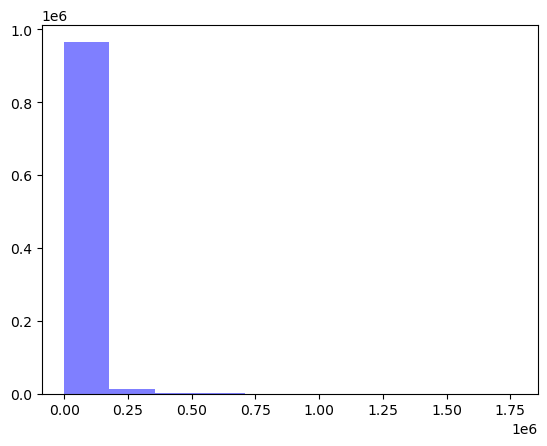

In [16]:
plt.hist(df['종가'], bins=10, facecolor='blue', alpha=0.5)
plt.show()

In [17]:
st=df.copy()

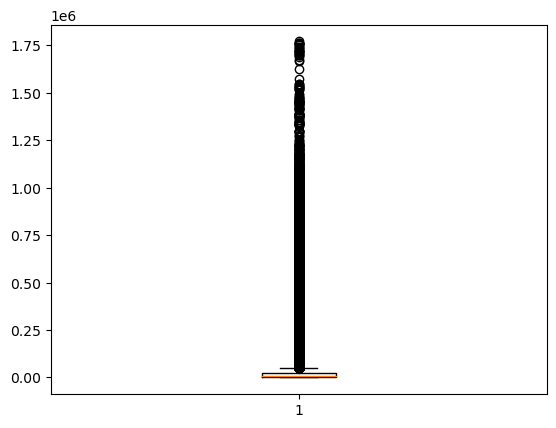

In [18]:
plt.boxplot(st['종가'])
plt.show()

In [19]:
st.describe()

,일자,거래량,시가,고가,저가,종가,금리,CPI,REG
count,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,9.880000e+05,988000.000000,988000.000000,988000.000000
mean,2.021974e+07,7.734265e+05,2.587701e+04,2.634938e+04,2.542335e+04,2.600283e+04,1.933198,4.238664,2.840081
std,6.822396e+03,4.839914e+06,6.590845e+04,6.689822e+04,6.490307e+04,6.587082e+04,1.109671,1.218774,1.071386
min,2.021060e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.500000e+01,0.500000,2.300000,1.300000
25%,2.021113e+07,3.653900e+04,3.775000e+03,3.865000e+03,3.700000e+03,3.890000e+03,1.000000,3.200000,2.600000
50%,2.022053e+07,1.140220e+05,8.630000e+03,8.810000e+03,8.470000e+03,8.700000e+03,1.750000,4.150000,2.600000
75%,2.022113e+07,3.672998e+05,2.130000e+04,2.180000e+04,2.085000e+04,2.140000e+04,3.250000,5.400000,4.300000
max,2.023053e+07,7.822434e+08,1.770000e+06,1.784000e+06,1.756000e+06,1.770000e+06,3.500000,6.300000,4.300000


In [20]:
# 가장 낮게 거래된 종가 항목 확인 
st.loc[df['종가']==8.500000e+01	]
# 판타지오 : 85원

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리,CPI,REG
305717,20220110,A032800,판타지오,21750231,89,89,83,85,1.0,3.7,2.6


In [21]:
# 가장 높게 거래된 종가 항목 확인
st.loc[df['종가']==1.770000e+06]
# lg생활건강 : 1,770,000원

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리,CPI,REG
44131,20210701,A051900,LG생활건강,35712,1770000,1784000,1750000,1770000,0.5,2.6,4.3


### 저가와 종가의 차이가 많이남... 나중에 정확도가 많이 떨어질 경우 한 번 더 확인 후 일반화를 위한 전처리 진행

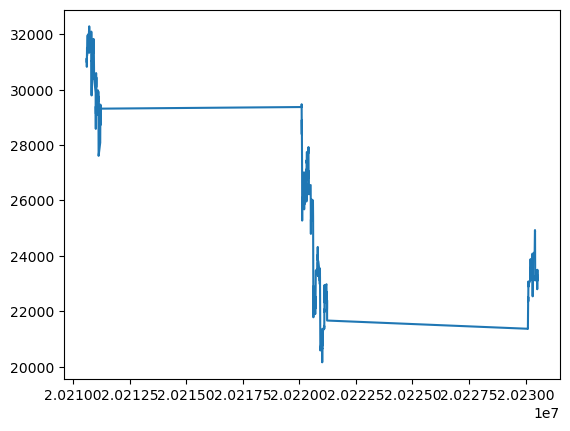

In [22]:
# 일자별 주식 추세 확인
close_price_by_date = df.groupby("일자").종가.mean()

# 시각화
plt.plot(close_price_by_date)

In [23]:
# 떨어졌다 유지되엇다 다시 급락했다 조금 오르고 있음
# 급락이 너무 심각함. 급락이 없는 구간으로 학습모델 만들어서 예측해볼 필요 있음

In [24]:
close_price_by_date.describe()

count      494.000000
mean     26002.830448
std       3512.824425
min      20155.027500
25%      22993.980750
50%      25390.413500
75%      29301.288250
max      32291.252500
Name: 종가, dtype: float64

In [25]:
close_price_by_date

일자
20210601    31017.8200
20210602    31049.3870
20210603    31135.4565
20210604    31056.5345
20210607    31078.4310
               ...    
20230523    23496.9545
20230524    23450.2105
20230525    23238.3535
20230526    23102.5045
20230530    23195.9345
Name: 종가, Length: 494, dtype: float64

# 20210601~ 202205 까지가 그나마 안정화 구간
# 안정화 구간을 토대로 모델링을 진행하도록 함

In [26]:
# 종목명별 중간값을 가지고 비싼 애들부터 인코딩해주기
st_price = st.groupby('종목명')['종가'].agg('mean').sort_values(ascending=False)
print('변환전\n', st_price[:5])

변환전
 종목명
LG생활건강      927289.473684
태광산업        919595.141700
삼성바이오로직스    837560.728745
LG화학        671966.599190
삼성SDI       656896.761134
Name: 종가, dtype: float64


In [27]:
#가격별로 0~ 인코딩 해주기
for i, a in enumerate(list(st_price.index)):
    st.loc[df['종목명'] == a, '종목명'] = i 
st_price = st.groupby('종목명')['종가'].agg('mean').sort_values(ascending=False)
print('변환후\n', st_price[:5])

변환후
 종목명
0    927289.473684
1    919595.141700
2    837560.728745
3    671966.599190
4    656896.761134
Name: 종가, dtype: float64


In [28]:
st.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,금리,CPI,REG
0,20210601,A060310,1681,166690,2890,2970,2885,2920,0.5,2.3,4.3
1,20210601,A095570,1290,63836,5860,5940,5750,5780,0.5,2.3,4.3
2,20210601,A006840,529,103691,35500,35600,34150,34400,0.5,2.3,4.3
3,20210601,A054620,741,462544,14600,14950,13800,14950,0.5,2.3,4.3
4,20210601,A265520,498,131987,29150,29150,28800,29050,0.5,2.3,4.3


In [29]:
stock=st.copy()

In [30]:
# 분석 보기 편하기 위해 컬럼명 변경
stock.columns = ['date', 'code', 'name', 'volume', 'start', 'high', 'low','finish','interest','cpi','reg']

In [31]:
stock.head()

,date,code,name,volume,start,high,low,finish,interest,cpi,reg
0,20210601,A060310,1681,166690,2890,2970,2885,2920,0.5,2.3,4.3
1,20210601,A095570,1290,63836,5860,5940,5750,5780,0.5,2.3,4.3
2,20210601,A006840,529,103691,35500,35600,34150,34400,0.5,2.3,4.3
3,20210601,A054620,741,462544,14600,14950,13800,14950,0.5,2.3,4.3
4,20210601,A265520,498,131987,29150,29150,28800,29050,0.5,2.3,4.3


In [32]:
# code+ name -> name만 남기기
stock = stock.drop(['code'], axis=1)
stock.head()

,date,name,volume,start,high,low,finish,interest,cpi,reg
0,20210601,1681,166690,2890,2970,2885,2920,0.5,2.3,4.3
1,20210601,1290,63836,5860,5940,5750,5780,0.5,2.3,4.3
2,20210601,529,103691,35500,35600,34150,34400,0.5,2.3,4.3
3,20210601,741,462544,14600,14950,13800,14950,0.5,2.3,4.3
4,20210601,498,131987,29150,29150,28800,29050,0.5,2.3,4.3


In [33]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      988000 non-null  int64  
 1   name      988000 non-null  object 
 2   volume    988000 non-null  int64  
 3   start     988000 non-null  int64  
 4   high      988000 non-null  int64  
 5   low       988000 non-null  int64  
 6   finish    988000 non-null  int64  
 7   interest  988000 non-null  float64
 8   cpi       988000 non-null  float64
 9   reg       988000 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 75.4+ MB


In [34]:
# name 자료형 변환 (카테고리형으로)
stock['name'] = stock['name'].astype('category').cat.codes

In [35]:
stock.head()

,date,name,volume,start,high,low,finish,interest,cpi,reg
0,20210601,1681,166690,2890,2970,2885,2920,0.5,2.3,4.3
1,20210601,1290,63836,5860,5940,5750,5780,0.5,2.3,4.3
2,20210601,529,103691,35500,35600,34150,34400,0.5,2.3,4.3
3,20210601,741,462544,14600,14950,13800,14950,0.5,2.3,4.3
4,20210601,498,131987,29150,29150,28800,29050,0.5,2.3,4.3


In [36]:
stock.tail()

,date,name,volume,start,high,low,finish,interest,cpi,reg
987995,20230530,1620,272284,3005,3035,2955,2980,3.5,3.3,1.3
987996,20230530,1562,50218,3250,3255,3195,3215,3.5,3.3,1.3
987997,20230530,1816,130664,1344,1395,1340,1370,3.5,3.3,1.3
987998,20230530,1041,141932,9170,9260,9170,9200,3.5,3.3,1.3
987999,20230530,1078,2611843,6410,8220,6300,8220,3.5,3.3,1.3


In [37]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988000 entries, 0 to 987999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      988000 non-null  int64  
 1   name      988000 non-null  int16  
 2   volume    988000 non-null  int64  
 3   start     988000 non-null  int64  
 4   high      988000 non-null  int64  
 5   low       988000 non-null  int64  
 6   finish    988000 non-null  int64  
 7   interest  988000 non-null  float64
 8   cpi       988000 non-null  float64
 9   reg       988000 non-null  float64
dtypes: float64(3), int16(1), int64(6)
memory usage: 69.7 MB


In [38]:
# 추후 종가를 예측해야 하기 때문에 종가를 맨 뒤로...
#데이터 재배열
stock = stock[['date', 'name', 'volume','start','high','low','interest', 'cpi', 'reg','finish']]
stock.head()

,date,name,volume,start,high,low,interest,cpi,reg,finish
0,20210601,1681,166690,2890,2970,2885,0.5,2.3,4.3,2920
1,20210601,1290,63836,5860,5940,5750,0.5,2.3,4.3,5780
2,20210601,529,103691,35500,35600,34150,0.5,2.3,4.3,34400
3,20210601,741,462544,14600,14950,13800,0.5,2.3,4.3,14950
4,20210601,498,131987,29150,29150,28800,0.5,2.3,4.3,29050


In [39]:
#20210601~20220531까지만 모델에 적용하는 것으로...

In [40]:
stock1 = stock[stock["date"] <= 20220531]

In [41]:
stock1.head()

,date,name,volume,start,high,low,interest,cpi,reg,finish
0,20210601,1681,166690,2890,2970,2885,0.5,2.3,4.3,2920
1,20210601,1290,63836,5860,5940,5750,0.5,2.3,4.3,5780
2,20210601,529,103691,35500,35600,34150,0.5,2.3,4.3,34400
3,20210601,741,462544,14600,14950,13800,0.5,2.3,4.3,14950
4,20210601,498,131987,29150,29150,28800,0.5,2.3,4.3,29050


In [42]:
stock1.tail()

,date,name,volume,start,high,low,interest,cpi,reg,finish
495995,20220531,1620,373206,3900,3930,3850,1.75,4.8,2.6,3870
495996,20220531,1562,99793,3750,3860,3735,1.75,4.8,2.6,3855
495997,20220531,1816,348676,2945,2950,2895,1.75,4.8,2.6,2940
495998,20220531,1041,120626,7340,7390,7250,1.75,4.8,2.6,7320
495999,20220531,1078,8386,8010,8090,7950,1.75,4.8,2.6,8050


# 상관관계 분석

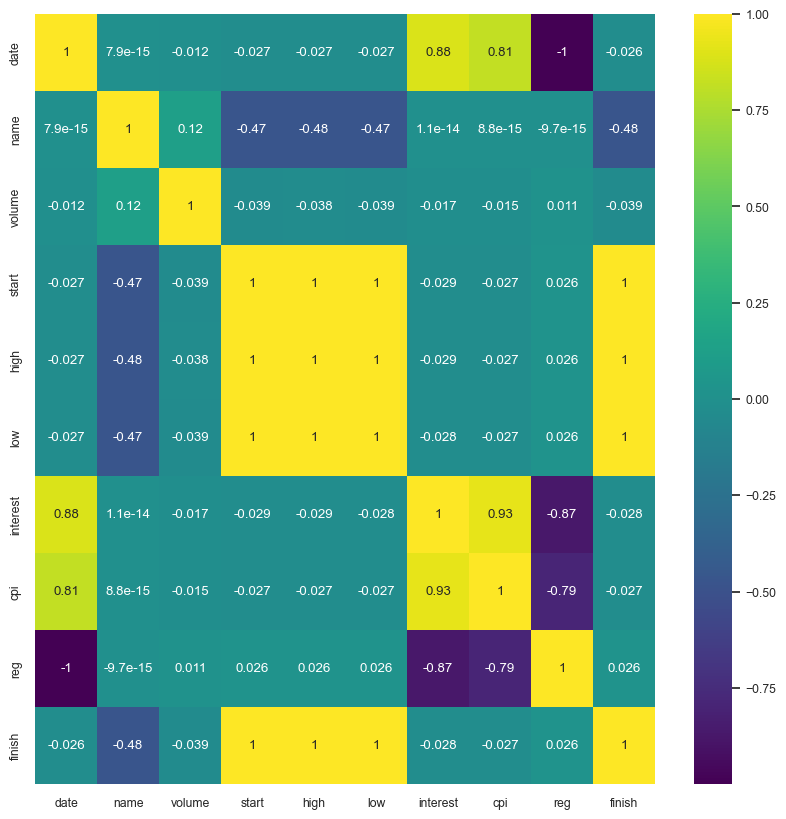

In [43]:
# 상관분석 진행

#상관관계 행렬
st_corr=stock1.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(st_corr, annot=True, cmap="viridis")
plt.show()

In [44]:
# 서로 다른 기준점이기 때문에 각 변수간의 다중공선성x

# 종가와 관련있는 변수 (high,start,low는 본인가)
corr_order = st_corr.corr()['finish'].abs().sort_values(ascending=False)
corr_order

finish      1.000000
high        0.999998
low         0.999998
start       0.999998
name        0.887898
volume      0.338845
cpi         0.281711
interest    0.272340
date        0.238850
reg         0.236048
Name: finish, dtype: float64

In [45]:
# 종가는 종목명에 가장 영향을 많이 받음
# 순서대로 소비자물가지수와 금리, 경제성장률에도 영향을 받는 것으로 나타남

# 시간이 지날수록 경제성장률이 좋지 않다는 것을 알 수 있음
# 시간이 지날수록 금리가 점점 올라가고 있음을 알 수 있음
# 금리가 오를수록 경제성장률이 좋지 않음
# 금리가 오를수록 소비자물가지수가 오름(인플레 높아짐)

In [46]:
'''
# pca 확인
# PCA를 수행
pca = PCA()
pca.fit(stock)

# PCA 결과 해석
print(pca.explained_variance_ratio_)
'''

'\n# pca 확인\n# PCA를 수행\npca = PCA()\npca.fit(stock)\n\n# PCA 결과 해석\nprint(pca.explained_variance_ratio_)\n'

In [47]:
#그룹별로 묶기 (2000개 레코드로 묶는 작업)
stock_group1 = stock1.groupby('name')
stock_group = stock.groupby('name')

In [48]:
stock_summary1 = stock_group1.agg({'volume': 'mean', 'start': 'mean', 'high': 'max', 'low': 'min', 'interest': 'mean', 'cpi': 'mean', 'reg': 'mean', 'finish': 'mean'})

In [49]:
stock_summary = stock_group1.agg({'volume': 'mean', 'start': 'mean', 'high': 'max', 'low': 'min', 'interest': 'mean', 'cpi': 'mean', 'reg': 'mean', 'finish': 'mean'})

In [50]:
stock_summary1.head()

,volume,start,high,low,interest,cpi,reg,finish
name,,,,,,,,
0,55341.298387,1.196758e+06,1784000,657000,0.946573,3.281452,3.607661,1.193415e+06
1,822.677419,1.064077e+06,1318000,915000,0.946573,3.281452,3.607661,1.063181e+06
2,78213.302419,8.546532e+05,1047000,693000,0.946573,3.281452,3.607661,8.542863e+05
3,305183.625000,6.980565e+05,910000,437000,0.946573,3.281452,3.607661,6.960867e+05
4,285271.754032,6.640948e+05,828000,462500,0.946573,3.281452,3.607661,6.634637e+05


In [51]:
stock_summary1['name'] = stock['name']

In [52]:
stock_summary['name'] = stock['name']

In [53]:
stock_summary1.head()

,volume,start,high,low,interest,cpi,reg,finish,name
name,,,,,,,,,
0,55341.298387,1.196758e+06,1784000,657000,0.946573,3.281452,3.607661,1.193415e+06,1681
1,822.677419,1.064077e+06,1318000,915000,0.946573,3.281452,3.607661,1.063181e+06,1290
2,78213.302419,8.546532e+05,1047000,693000,0.946573,3.281452,3.607661,8.542863e+05,529
3,305183.625000,6.980565e+05,910000,437000,0.946573,3.281452,3.607661,6.960867e+05,741
4,285271.754032,6.640948e+05,828000,462500,0.946573,3.281452,3.607661,6.634637e+05,498


In [54]:
stock_summary1 = stock_summary[['name', 'volume', 'start', 'high', 'low', 'interest', 'cpi', 'reg', 'finish']]

In [55]:
stock_summary = stock_summary[['name', 'volume', 'start', 'high', 'low', 'interest', 'cpi', 'reg', 'finish']]

In [56]:
stock_summary1.head()

,name,volume,start,high,low,interest,cpi,reg,finish
name,,,,,,,,,
0,1681,55341.298387,1.196758e+06,1784000,657000,0.946573,3.281452,3.607661,1.193415e+06
1,1290,822.677419,1.064077e+06,1318000,915000,0.946573,3.281452,3.607661,1.063181e+06
2,529,78213.302419,8.546532e+05,1047000,693000,0.946573,3.281452,3.607661,8.542863e+05
3,741,305183.625000,6.980565e+05,910000,437000,0.946573,3.281452,3.607661,6.960867e+05
4,498,285271.754032,6.640948e+05,828000,462500,0.946573,3.281452,3.607661,6.634637e+05


In [57]:
# 정규화하기
# MinMaxScaler 클래스 생성
scaler = MinMaxScaler()

# MinMaxScaler 클래스의 fit_transform() 메서드 사용 데이터 정규화
normalized_data = scaler.fit_transform(stock_summary1)

# 정규화된 데이터, 데이터 프레임으로 다시 변환
ndf = pd.DataFrame(normalized_data, columns=stock_summary1.columns)


ormalized_data = scaler.fit_transform(stock_summary)
ndf1 = pd.DataFrame(normalized_data, columns=stock_summary.columns)

In [58]:
ndf.head()

,name,volume,start,high,low,interest,cpi,reg,finish
0,0.840920,0.001359,1.000000,1.000000,0.718033,0.0,0.0,0.0,1.000000
1,0.645323,0.000020,0.889133,0.738789,1.000000,0.0,0.0,0.0,0.890847
2,0.264632,0.001921,0.714140,0.586883,0.757377,0.0,0.0,0.0,0.715766
3,0.370685,0.007495,0.583290,0.510090,0.477596,0.0,0.0,0.0,0.583175
4,0.249125,0.007006,0.554911,0.464126,0.505464,0.0,0.0,0.0,0.555832


In [59]:
stock_ndf = pd.DataFrame(ndf).to_csv('../data/stock/ndf.csv', index=False)

# 모델링

In [60]:
# 데이터 나누기
X = ndf.iloc[:, :-1]
y = ndf.iloc[:,[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
X_train.head()

,name,volume,start,high,low,interest,cpi,reg
610,0.162081,0.007004,0.016080,0.014098,0.014153,0.0,0.0,0.0
1315,0.206103,0.065705,0.005605,0.005348,0.005792,0.0,0.0,0.0
1919,0.571286,0.064129,0.000922,0.001536,0.000000,0.0,0.0,0.0
1008,0.983492,0.010756,0.007939,0.008128,0.007333,0.0,0.0,0.0
146,0.347674,0.003909,0.079568,0.083520,0.070383,0.0,0.0,0.0


In [62]:
y_train.head()

,finish
610,0.015898
1315,0.005383
1919,0.000703
1008,0.007739
146,0.079460


In [63]:
print(X_train.shape)
print(y_train.shape)

(1600, 8)
(1600, 1)


In [64]:
print(X_test.shape)
print(y_test.shape)

(400, 8)
(400, 1)


In [65]:
X_train_csv = pd.DataFrame(X_train).to_csv('../data/stock/X_train.csv', index=False)
y_train_csv = pd.DataFrame(y_train).to_csv('../data/stock/y_train.csv', index=False)
X_test_csv = pd.DataFrame(X_test).to_csv('../data/stock/X_test.csv', index=False)
y_test_csv = pd.DataFrame(y_test).to_csv('../data/stock/y_test.csv', index=False)

In [66]:
from tensorflow.keras.layers import Dropout

from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2

'''
model = Sequential([
  LSTM(32, activation='relu', return_sequences=True,  input_shape=(ndf.shape[1] - 1, 1)),
  Dropout(0.4),
  LSTM(units=32, activation='relu'),
  Dropout(0.4),
  Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(), kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mse')
'''
'''
model = Sequential([
  LSTM(64, activation='relu', return_sequences=True,  input_shape=(ndf.shape[1] - 1, 1)),
  Dropout(0.2),
  LSTM(units=32, activation='relu'),
  Dropout(0.2),
  Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse')
'''
'''
model = Sequential([
  LSTM(64, activation='relu', return_sequences=True,  input_shape=(ndf.shape[1] - 1, 1)),
  Dropout(0.4),
  LSTM(units=64, activation='relu'),
  Dropout(0.4),
  Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(optimizer=optimizer, loss='mse')

'''

tf.random.set_seed(1)

model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True,  input_shape=(ndf.shape[1] - 1, 1)))
model.add(LSTM(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 학습하기
history = model.fit(X_train, y_train, epochs=12, batch_size=80, validation_split=0.2, verbose=1)

Epoch 1/12
16/16 [==============================] - 3s 42ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 2/12
16/16 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/12
16/16 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 4/12
16/16 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 8.3423e-04
Epoch 5/12
16/16 [==============================] - 0s 12ms/step - loss: 9.5582e-04 - val_loss: 2.3320e-04
Epoch 6/12
16/16 [==============================] - 0s 12ms/step - loss: 8.3323e-04 - val_loss: 2.5800e-04
Epoch 7/12
16/16 [==============================] - 0s 13ms/step - loss: 7.2570e-04 - val_loss: 3.3514e-04
Epoch 8/12
16/16 [==============================] - 0s 12ms/step - loss: 4.5807e-04 - val_loss: 2.5912e-04
Epoch 9/12
16/16 [==============================] - 0s 13ms/step - loss: 6.5549e-04 - val_loss: 3.1508e-04
Epoch 10/12
16/16 [==============================] - 0s 13ms/step

In [68]:
# 예측하기
pred = model.predict(X_test)
print(y_test.shape, pred.shape)

13/13 [==============================] - 0s 3ms/step
(400, 1) (400, 1)


In [69]:
# 실제값과 예측값 확인하기
predictions = np.array(pred)
actual_values = np.array(y_test)

In [70]:
# RMSE를 계산(낮을 수록 정확함)
rmse = mean_squared_error(y_test, predictions)
print('rmse :',rmse)

# R^2을 계산(R^2가 1에 가까울수록 모델이 데이터를 잘 설명)
r2 = r2_score(y_test, predictions)
print('r2 :',r2)

# MAE를 계산(MAE가 낮을수록 예측값과 실제값이 가까워짐)
mae = mean_absolute_error(y_test, predictions)
print('mae :',mae)

rmse : 0.00039359661764608653
r2 : 0.7849264177088178
mae : 0.014960880560926714


In [71]:
# 예측값과 실제값
X_test['predict'] = pred
X_test['real'] = y_test['finish']

In [72]:
X_test.head()

,name,volume,start,high,low,interest,cpi,reg,predict,real
1104,0.684842,0.005137,0.007047,0.005594,0.007661,0.0,0.0,0.0,0.017825,0.006825
1384,0.223112,0.015003,0.005151,0.005034,0.004710,0.0,0.0,0.0,0.019094,0.004923
677,0.686843,0.000388,0.014211,0.012864,0.015628,0.0,0.0,0.0,0.020274,0.014026
1588,0.526763,0.013262,0.003490,0.003374,0.003623,0.0,0.0,0.0,0.017395,0.003271
220,0.873437,0.000804,0.051564,0.044843,0.053989,0.0,0.0,0.0,0.040858,0.051370


In [73]:
modelResult = pd.DataFrame(X_test).to_csv('../data/stock/result.csv', index=False)

In [ ]:
# 값 예측하기

In [ ]:
# 데이터 나누기
x_data = ndf1.iloc[:, :-1]
y_data = ndf1.iloc[:,[-1]]

In [ ]:
x_data.head()

In [ ]:
x_data.describe()

In [ ]:
y_data.head()

In [ ]:
predict_close = model.predict(x_data)

In [ ]:
x_data['predict_close'] = predict_close
x_data['real_close'] = y_data['finish']

In [ ]:
x_data.head()

In [ ]:
x_data['name'] = st['종목명']

In [ ]:
x_data.head()

In [ ]:
re = x_data[['predict_close', 'real_close']]

In [ ]:
re.head()

In [ ]:
# x_renorm = x_norm * (max_value - min_value) + min_value

In [ ]:
max_value = 1.770000e+06
min_value= 8.500000e+01
    
re['predict_close'] = re['predict_close'] * (max_value - min_value) + min_value
re['real_close'] = re['real_close'] * (max_value - min_value) + min_value    

In [ ]:
re.head()

In [ ]:
re['return'] = (re['predict_close'] - re['real_close']) / re['real_close']

In [ ]:
re.head()

In [ ]:
re['code'] = st['종목코드']

In [ ]:
re.head()

In [ ]:
re.describe()

In [ ]:
res_data = re[['code','return']]

In [ ]:
res_data.head()

In [ ]:
res_data.describe()

In [ ]:
# 마이너스값 양수로 만들어주기, 수익률은 -1보다 크기 때문에 그냥 1을 더해 양수로 만드어준다.
# (수익률 문제라 같은 값으로 더해주면 크게 상관없음)
res_data['re_return'] = res_data['return'].map(lambda x: x+1)

In [ ]:
#오류값 있는지 확인(inf / NaN)
if np.isinf(res_data['re_return']).any():
    print('inf값이 있음.')

if np.isnan(res_data['re_return']).any():
    print('NaN값이 있음.')

#없음

In [ ]:
res_data.head()

In [ ]:
res_data.describe()

In [ ]:
# 같은 값 있는지 확인

In [ ]:
if res_data["re_return"].duplicated().any():
    print("`re_return` 열에 같은 값이 있음.")
else:
    print("`re_return` 열에 같은 값이 없음.")

In [ ]:
# return값 큰값부터 1~ 순위 부여
res_data = res_data.sort_values("re_return", ascending=False)
res_data["re_return_rank"] = res_data["re_return"].rank(ascending=False)

In [ ]:
res_data.head()

In [ ]:
res_data["re_return_rank"] = res_data["re_return_rank"].astype(int)

In [ ]:
res_data.head()

In [ ]:
#필요한 피처만 남기기
final = res_data[['code','re_return_rank']]

In [ ]:
final.head()

In [ ]:
#1~2000까지 잘 들어갔는지 확인
final.describe()

In [ ]:
#제출 준비

In [ ]:
final.rename(columns={'code': '종목코드', 're_return_rank': '순위'}, inplace=True)

In [ ]:
final.head()

In [ ]:
submit = pd.read_csv('../data/stock/sample_submission.csv')

In [ ]:
submit.head()

In [ ]:
final_submit = submit[['종목코드']].merge(final[['종목코드', '순위']], on='종목코드', how='left')
final_submit

In [ ]:
final_submit.to_csv('../data/stock/final_submit2.csv', index=False)

In [ ]:
final_submit.head()